In [1]:
from helpers import *
from dataset import *
from model2 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
import random
import torchvision.transforms as T
from torch.utils.data import DataLoader
import cv2
import math

In [2]:
mask_size2 = {key: math.floor(value * 0.7) for key, value in mask_size.items()}
mask_size2

{'defolt': 0,
 'apo-ferritin': 4,
 'beta-amylase': 4,
 'beta-galactosidase': 6,
 'ribosome': 10,
 'thyroglobulin': 9,
 'virus-like-particle': 9}

(6, 184, 630, 630)
(6, 184, 630, 630)


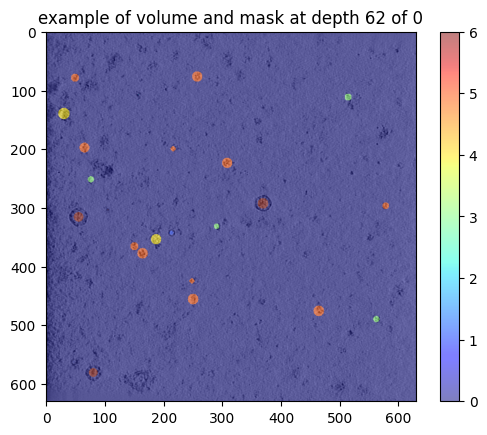

In [3]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
test_id = ["TS_5_4"]

volumes = np.empty((len(valid_id), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id), 184, 630, 630), dtype=np.uint8)

for idx in range(len(valid_id)):
    data = read_one_data(valid_id[idx], train_dir)
    data = data.astype(np.float32)
    volumes[idx, :, :, :] = data
    
    y = read_one_truth(valid_id[idx], mask_dir)
    mask_data = generate_mask(y, mask_size2)
    mask_data = mask_data.astype(np.uint8)
    masks[idx, :, :, :] = mask_data

print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=62)

In [4]:
vol_data = []
mask_data = []
for exp in range(len(valid_id)):
    volume = volumes[exp, :, :, :]
    mask = masks[exp, :, :, :]
    print("exp=", exp)
    
    #何もなし
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=0, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_data.append(vol_slices)
    mask_data.append(mask_slices)
    # 180度回転
    process_rotation_and_slicing(volume, mask, anglex=180, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_data.append(vol_slices)
    mask_data.append(mask_slices)
    
    #反転
    process_rotation_and_slicing(volume, mask, anglex=180, angley=180, anglez=0, zz_range=range(48, 136, 16))
    vol_data.append(vol_slices)
    mask_data.append(mask_slices)

    #斜め
    process_rotation_and_slicing(volume, mask, anglex=5, angley=5, anglez=5, zz_range=range(48, 184, 16))
    vol_data.append(vol_slices)
    mask_data.append(mask_slices)

vol_data = np.array(vol_data).reshape(-1, 32, 640, 640)
mask_data = np.array(mask_data).reshape(-1, 32, 640, 640)

print("vol_data shape:", vol_data.shape)
print("mask_data shape:", mask_data.shape)

exp= 0
-41 36 44
15 26 28
19 62 12
-5 -29 -4
34 32 -20
26 -15 -36
1 -81 -52
2 27 -68
-53 79 -84
77 -66 44
16 -40 28
82 -30 12
-74 -100 -4
60 -76 -20
54 -15 -36
-58 25 -52
24 87 -68
-86 -74 -84
-30 25 44
-28 -54 28
73 41 12
-14 -42 -4
-99 -65 -20
-99 17 -36
67 -62 44
-66 -89 28
-44 -76 12
-9 -22 -4
29 -56 -20
-62 -22 -36
-8 -7 -52
-83 -27 -68
80 -89 -84
exp= 1
-7 -92 44
100 -27 28
21 -37 12
-89 -55 -4
-42 -32 -20
0 18 -36
-47 57 -52
56 38 -68
43 -38 -84
-18 65 44
59 -82 28
82 -78 12
-93 40 -4
44 73 -20
100 -26 -36
-44 -98 -52
-27 -68 -68
-13 -93 -84
-23 76 44
52 -10 28
22 95 12
33 45 -4
49 -21 -20
10 -68 -36
-60 -94 44
-54 30 28
47 -93 12
65 -66 -4
-41 -21 -20
90 -8 -36
-86 -22 -52
-67 34 -68
-40 -82 -84
exp= 2
87 -63 44
45 -99 28
60 -95 12
-17 -68 -4
-33 -56 -20
-77 36 -36
-10 -95 -52
-51 -53 -68
69 23 -84
-84 -100 44
72 -37 28
1 -55 12
-99 30 -4
-29 -91 -20
-4 67 -36
21 -56 -52
46 -57 -68
-41 -71 -84
20 -100 44
-17 -55 28
54 -92 12
-12 88 -4
-93 -51 -20
-74 -15 -36
-79 9 44
-24 -97 28

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class VolumeDataset(Dataset):
    def __init__(self, vol_data, mask_data, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 入力データ (216, 32, 640, 640) の形。
            mask_data (numpy.ndarray): ラベルデータ (216, 32, 640, 640) の形。
            transform (callable, optional): 入力データに適用する変換処理。
        """
        self.vol_data = torch.tensor(vol_data, dtype=torch.float32)  # Tensor に変換
        self.mask_data = torch.tensor(mask_data, dtype=torch.float32)  # Tensor に変換
        self.transform = transform

    def __len__(self):
        # データの数を返す
        return len(self.vol_data)

    def __getitem__(self, idx):
        # 指定された idx のデータを返す
        volume = self.vol_data[idx]  # 入力データ
        mask = self.mask_data[idx]  # ラベルデータ

        if self.transform:
            volume = self.transform(volume)

        return volume, mask

In [6]:
# Dataset のインスタンスを作成
dataset = VolumeDataset(vol_data, mask_data)

# DataLoader のインスタンスを作成
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(pretrained=True,cfg=None).cuda()

cuda


In [8]:
num_epochs = 40  # エポック数
learning_rate = 1e-3  # 学習率

optimizer = torch.optim.AdamW(
    net.parameters(), 
    lr=learning_rate,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable= False,
    eps=1e-08,
    foreach=None,
    fused=None,
    weight_decay=0.01,
    )

# 損失を記録するリスト
epoch_losses = []

for epoch in range(num_epochs):

    #5回ごとにoptimizerをリセットする
    if epoch % 5 == 0:
        optimizer = torch.optim.AdamW(
            net.parameters(), 
            lr=learning_rate,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable= False,
            eps=1e-08,
            foreach=None,
            fused=None,
            weight_decay=0.01,
            )
        

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }
        optimizer.zero_grad()

        with torch.amp.autocast("cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']

        for k, v in output.items():
            if 'loss' in k:
                print(f'{k:>32} : {v.item()} ')    

        running_loss += loss.item()  # ミニバッチごとの損失を加算

        loss.backward()
        optimizer.step()

    # エポックごとの平均損失を計算して記録
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"損失: {epoch_loss:.4f}")

エポック 1/40
----------
                       mask_loss : 1.8675720691680908 
                       mask_loss : 1.8716806173324585 
                       mask_loss : 1.857580542564392 
                       mask_loss : 1.8559085130691528 
                       mask_loss : 1.8474485874176025 
                       mask_loss : 1.8638191223144531 
                       mask_loss : 1.8360060453414917 
                       mask_loss : 1.8337693214416504 
                       mask_loss : 1.81266188621521 
                       mask_loss : 1.8144850730895996 
                       mask_loss : 1.8119707107543945 
                       mask_loss : 1.8086775541305542 
                       mask_loss : 1.7993378639221191 
                       mask_loss : 1.7922512292861938 
                       mask_loss : 1.7935186624526978 
                       mask_loss : 1.7983312606811523 
                       mask_loss : 1.7665961980819702 
                       mask_loss : 1.7662723064

KeyboardInterrupt: 

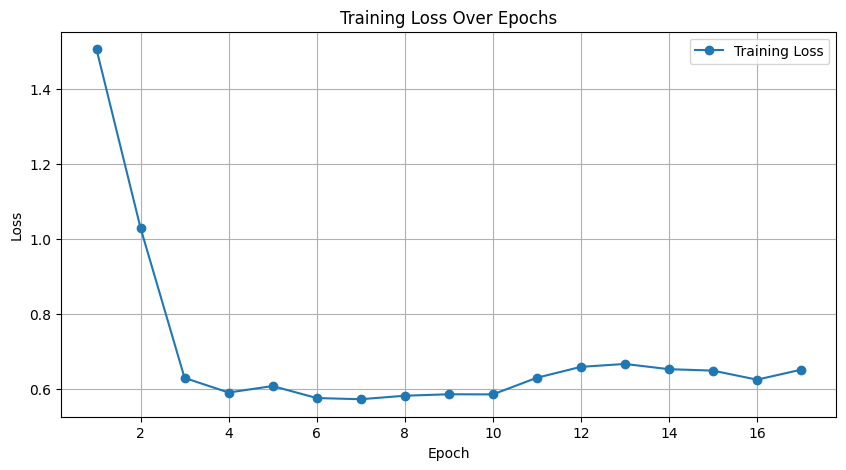

In [11]:
# 損失の推移をグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(1, 18), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()